In [1]:
# Imports
from music21 import converter, instrument, note, chord, stream, midi
import glob
import time
import numpy as np
import keras.utils as utils
import pandas as pd

Using TensorFlow backend.


# Music Generation with an RNN

- Music is a complex phenomenon with many representations (e.g., digital audio, musical scores, lead sheets)
- A simple representation of music is as a sequence of notes and rests:
    - (equivalent to one line of melody)
- This can be one-hot encoded and applied to a CharRNN!

## A simple music representation

- Our musical representation is going be a sequence of integers between 0 and 129.
- Each integer represents a musical instruction lasting for one sixteenth note (one semiquaver) of duration.
    - This is a typical level of detail for electronic music sequencers.
- MIDI is a standard way of encoding instructions for synthesised instruments and can represent whole musical scores.
    - Standard MIDI allows 128 pitches (there are only 88 on a piano keyboard) where number 60 is 'middle C'.
    
#### Melody-RNN Encoding

- 0-127 play a note at that MIDI note number. (`MELODY_NOTE_ON`)
- 128 stop whatever note was playing. (`MELODY_NOTE_OFF`)
- 129 do nothing. (`MELODY_NO_EVENT`)
    
This encoding should allow long notes (a note-on followed by one or more no-change events, then a note-off), and rests (a note-off followed by one or more no-change events).

Here's a standard melody converted into this format:

![](figures/wm_score_example.png)

NB: Google's [Magenta project](https://magenta.tensorflow.org/) have created some really great musical RNNs, with lots of advanced features. This script focusses on simplicity and clarity instead!

### Convert between MIDI files and numpy arrays in melody format

- Music is more complex than text (e.g., more than one note might happen at once). 
- We use the Music21 library to read MIDI music filescand then convert to our Melody-RNN format.
- The functions below turn a Music21 "stream" (of notes) into a numpy array of 8-bit integers.
- All complex rhythms are simplified to sixteenth note versions.
- Chords are simplified to the highest note.



In [2]:
# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output


def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream


In [ ]:
## Play a melody stream
# sp = midi.realtime.StreamPlayer(melody_stream)
# sp.play()

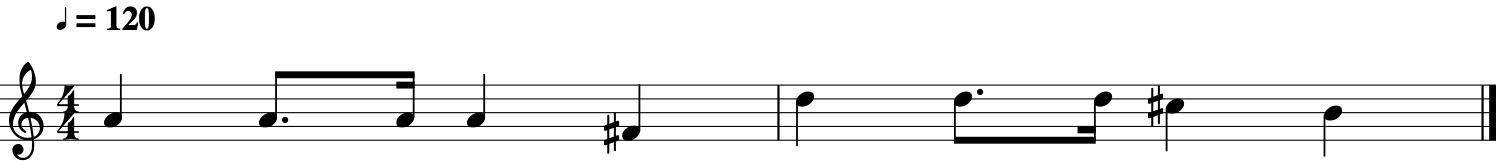

[ 69 129 129 129  69 129 129  69  69 129 129 129  66 129 129 129  74 129
 129 129  74 129 129  74  73 129 129 129  71 129 129 129 128]


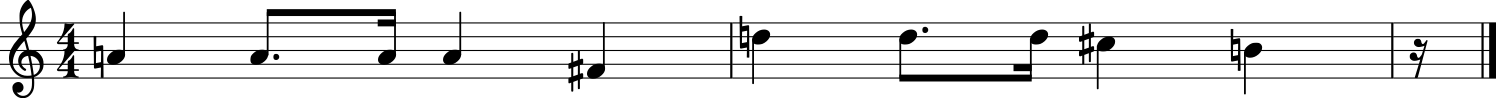

In [3]:
wm_mid = converter.parse("../datasets/waltzing-matilda.mid")
wm_mid.show()
wm_mel_rnn = streamToNoteArray(wm_mid)
print(wm_mel_rnn)
noteArrayToStream(wm_mel_rnn).show()

## Construct a dataset of popular melodies

Open some midi files and extract the melodies as numpy note sequence arrays.

In [5]:
import time
midi_files = glob.glob("/Users/charles/Dropbox/music/zelda-mid/*.mid") # this won't work, no files there.

training_arrays = []
for f in midi_files:
    try:
        start = time.clock()
        s = converter.parse(f)
        print("Parsed:", f, "it took", time.clock() - start)
    except:
        continue
    for p in s.parts:
        start = time.clock()
        arr = streamToNoteArray(p)
        training_arrays.append(arr)
        print("Converted:", f, "it took", time.clock() - start)

training_dataset = np.array(training_arrays)
np.savez('melody_training_dataset.npz', train=training_dataset)

Parsed: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.36058199999999374
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.6177539999999908
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.7052099999999939
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.4810060000000078
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.6193879999999865
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.03372800000002485
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.691960999999992
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64shop.mid it took 0.8092380000000219
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Title08.mid it took 0.04660400000000209
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title08.mid it took 0.20983799999999064
Converted: /Users/charles/Dropbox/music/zelda-mid

Converted: /Users/charles/Dropbox/music/zelda-mid/Z4finalboss.mid it took 0.8369219999999871
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4finalboss.mid it took 1.6811710000000062
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4finalboss.mid it took 1.7155840000000069
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4finalboss.mid it took 1.5051989999999762
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4finalboss.mid it took 0.738504000000006
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSsamasadesert.mid it took 0.36261899999999514
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSsamasadesert.mid it took 0.8504779999999812
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSsamasadesert.mid it took 0.4844129999999893
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSsamasadesert.mid it took 0.7398389999999893
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSsamasadesert.mid it took 0.5086960000000147
Con

Parsed: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.893758000000048
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.6487559999999917
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.9376450000000318
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.3957990000000109
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.36021199999999
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.3418190000000436
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fount.mid it took 0.35644700000000284
Parsed: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fairy.mid it took 0.7202760000000126
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fairy.mid it took 0.2401919999999791
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64fairy.mid it took 0.3136440000000107
Converted: /Users/charles/Dropbox/musi

Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.0403159999999616
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.0370829999999955
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.28617399999996
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.2283349999999587
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.7866020000000162
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.2276669999999967
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-OverworldRemix08.mid it took 1.11976599999997
Parsed: /Users/charles/Dropbox/music/zelda-mid/Z4gameover.mid it took 0.7848140000000399
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4gameover.mid it took 0.32601499999998396
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4gameover.mid it took 0.2937440000000038
Converted: /User

Parsed: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.5912120000000414
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.26989900000000944
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.39640200000002324
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.2937949999999887
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.2108400000000188
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Title_screen.mid it took 0.32179800000000114
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSancientruins.mid it took 2.2003069999999525
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSancientruins.mid it took 0.4441950000000361
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSancientruins.mid it took 0.5918970000000172
Converted: /Users/charles/Dropbox/music/zelda-mid/lozoos-z_OofSancientruins.mid it

Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PHmonster_ship.mid it took 0.5577710000000025
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PHmonster_ship.mid it took 0.31976500000001806
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PHmonster_ship.mid it took 0.3160880000000361
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-FinalDungeon01.mid it took 0.4027150000000006
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-FinalDungeon01.mid it took 0.12490700000000743
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-FinalDungeon01.mid it took 0.1128840000000082
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-FinalDungeon01.mid it took 0.17536499999999933
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozph-House.mid it took 1.012473
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-House.mid it took 0.3679019999999582
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-House.mid it took 0.2667879999999627
Converted: /Users/charles/Dr

Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.16430500000001302
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.023806999999976597
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.025934000000006563
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.019887000000039734
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.02278200000000652
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Triforce03.mid it took 0.020474999999976262
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozmm-Intro.mid it took 0.6117689999999811
Converted: /Users/charles/Dropbox/music/zelda-mid/lozmm-Intro.mid it took 0.5363270000000284
Converted: /Users/charles/Dropbox/music/zelda-mid/lozmm-Intro.mid it took 0.6572300000000268
Converted: /Users/charles/Dropbox/music/zelda-mid/lozmm-Intro.mid it took 0.5961389999999938
Converted: /Users/charles/Dropbox/music/zelda-mi

Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Outset_island.mid it took 0.35072999999999865
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Outset_island.mid it took 0.3138009999998985
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Outset_island.mid it took 0.48843299999998635
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Outset_island.mid it took 0.5118039999999837
Parsed: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3woods.mid it took 0.48196200000006684
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3woods.mid it took 0.19258899999999812
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3woods.mid it took 0.34097299999996267
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3woods.mid it took 0.18507599999998092
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3woods.mid it took 0.18903999999997723
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozooa-RoadToTheMakuTree.mid it took 0.35982399999988957
Con

Parsed: /Users/charles/Dropbox/music/zelda-mid/z2-z2title.mid it took 0.9942379999999957
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2title.mid it took 0.2909310000000005
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2title.mid it took 0.3229189999999562
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2title.mid it took 0.2694340000000466
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2title.mid it took 0.27309600000000955
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid it took 0.5973220000000765
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid it took 0.48853600000006736
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid it took 0.4908659999999827
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid it took 0.37956800000006297
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid it took 0.313590999999974
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon07.mid i

Converted: /Users/charles/Dropbox/music/zelda-mid/Z4overworld.mid it took 0.8429170000000568
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4overworld.mid it took 0.6389609999999948
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4overworld.mid it took 0.5031609999999773
Parsed: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.33080200000006243
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.2643479999999272
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.2981720000000223
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.1296980000000758
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.11666000000002441
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64owl.mid it took 0.2246900000000096
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Dungeon02.mid it took 0.18700200000000677
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Dunge

Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64markt.mid it took 0.32580399999994825
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64markt.mid it took 0.34168099999999413
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64markt.mid it took 0.37520100000006096
Converted: /Users/charles/Dropbox/music/zelda-mid/z64oot-z64markt.mid it took 0.5153589999999895
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 1.700984999999946
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 0.19177700000000186
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 0.486362999999983
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 0.23913800000002539
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 0.06582400000002053
Converted: /Users/charles/Dropbox/music/zelda-mid/lozph-PH_intro.mid it took 0.08269000000007054
Converted: /Users/charles/Dropbox/

Converted: /Users/charles/Dropbox/music/zelda-mid/Z4bottlegrotto.mid it took 1.0472260000000233
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4bottlegrotto.mid it took 0.6475759999999582
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4bottlegrotto.mid it took 0.4823790000000372
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4bottlegrotto.mid it took 0.5400349999999889
Converted: /Users/charles/Dropbox/music/zelda-mid/Z4bottlegrotto.mid it took 0.5876919999999473
Parsed: /Users/charles/Dropbox/music/zelda-mid/z2-lastempl.mid it took 1.8111840000000257
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-lastempl.mid it took 0.3613380000000461
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-lastempl.mid it took 0.39549799999997504
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-lastempl.mid it took 0.6863180000000284
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-lastempl.mid it took 0.43271200000003773
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-las

Parsed: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 2.657517000000098
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 0.6922799999999825
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 1.1499030000001085
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 0.599330000000009
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 0.6217820000001666
Converted: /Users/charles/Dropbox/music/zelda-mid/z3alttp-z3darkw1.mid it took 0.44086300000003575
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozooa-ralph.mid it took 0.23354599999993297
Converted: /Users/charles/Dropbox/music/zelda-mid/lozooa-ralph.mid it took 0.2942519999999149
Converted: /Users/charles/Dropbox/music/zelda-mid/lozooa-ralph.mid it took 0.27109599999994316
Converted: /Users/charles/Dropbox/music/zelda-mid/lozooa-ralph.mid it took 0.21136000000001332
Parsed: /Users/charles/Dropbox/music/zel

Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2temple.mid it took 0.8283209999999599
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 1.3960939999999482
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 0.31986199999983
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 0.5509859999999662
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 0.684003999999959
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 0.9341589999999087
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title06.mid it took 0.6131089999998949
Parsed: /Users/charles/Dropbox/music/zelda-mid/z2-z2cave.mid it took 1.041449000000057
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2cave.mid it took 0.23592899999994188
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2cave.mid it took 0.27151200000002973
Converted: /Users/charles/Dropbox/music/zelda-mid/z2-z2cave.mid it took 0.2490040000

Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Overworld_theme.mid it took 0.8070740000000569
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Overworld_theme.mid it took 0.567147999999861
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Overworld_theme.mid it took 0.5419520000000375
Converted: /Users/charles/Dropbox/music/zelda-mid/lozww-Overworld_theme.mid it took 0.9490260000000035
Parsed: /Users/charles/Dropbox/music/zelda-mid/loz-Title05.mid it took 0.4776520000000346
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title05.mid it took 0.2755290000000059
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title05.mid it took 0.3075800000001436
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title05.mid it took 0.36714200000005803
Converted: /Users/charles/Dropbox/music/zelda-mid/loz-Title05.mid it took 0.3666200000000117
Parsed: /Users/charles/Dropbox/music/zelda-mid/lozooa-z_OofAcrescentisland.mid it took 0.5976290000000972
Converted: /Users/ch

# Load Training Data and Create RNN

In the following we load in the training dataset, slice the melodies into example sequences and build our Melody RNN.

In [7]:
# Training Hyperparameters:
VOCABULARY_SIZE = 130 # known 0-127 notes + 128 note_off + 129 no_event
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 30
SEED = 2345  # 2345 seems to be good.
np.random.seed(SEED)

with np.load('./melody_training_dataset.npz') as data:
    train_set = data['train']

print("Training melodies:", len(train_set))

Training melodies: 1027


In [8]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
# This slices the melodies into sequences of length SEQ_LEN+1.
# Then, each sequence is split into an X of length SEQ_LEN and a y of length 1.

# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

# Look at the size of the training corpus:
print("Total Training Corpus:")
print("X:", X.shape)
print("y:", y.shape)
print()

# Have a look at one example:
print("Looking at one example:")
print("X:", X[95])
print("y:", y[95])
# Note: Music data is sparser than text, there's lots of 129s (do nothing)
# and few examples of any particular note on.
# As a result, it's a bit harder to train a melody-rnn.

Total Training Corpus:
X: (805073, 30)
y: (805073,)

Looking at one example:
X: [129 128 129 129 129 129 129  43 129  35 129 129 129  38 129 129 129 128
 129 129 129 129 129  31 129  43 129 129 129  41]
y: 129


In [ ]:
# Do some stats on the corpus.
all_notes = np.concatenate(train_set)
print("Number of notes:")
print(all_notes.shape)
all_notes_df = pd.DataFrame(all_notes)
print("Notes that do appear:")
unique, counts = np.unique(all_notes, return_counts=True)
print(unique)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique))

print("Plot the relative occurences of each note:")
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('dark_background')
plt.bar(unique, counts)
plt.yscale('log')
plt.xlabel('melody RNN value')
plt.ylabel('occurences (log scale)')

# Define the Training RNN

- The training RNN will be more complex than in the text examples.
- Using 2 layers of LSTM 256 LSTM cells each.
- Using an Embedding layer on the input (saves some effort in creating one-hot examples)
- Using sparse categorical cross entropy for loss (so that ys don't have to be one-hot)

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

# build the model: 2-layer LSTM network.
# Using Embedding layer and sparse_categorical_crossentropy loss function 
# to save some effort in preparing data.

print('Build model...')
model_train = Sequential()
model_train.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN))

# LSTM part
model_train.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_train.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_train.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_train.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_train.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 256)           33280     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 130)               33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Training

- I trained this model on Google's Colaboratory system (free online Python machine learning environment, including GPU).
- Good to train for lots of epochs, I tried for 100: less is possible.
- Takes around 3 minutes per epoch on an NVidia K80 GPU = 5 hours to train.

Here's the training diagram:

<img src="figures/training_melody_rnn.png" style="width: 600px;"/>

Probably could have stopped after about 50 epochs to save some time!

This trained model is included in the repo, so you can go ahead and load that, or train again with your own dataset.

In [ ]:
# Train the model (this takes time)
model_train.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)
model_train.save("zeldic-rnn.h5")

In [ ]:
# Load if necessary - don't need to do this.
# model_train = keras.models.load_model("zeldic-rnn.h5")

# Decoding Model

Now we build a 1-in, 1-out model for encoding. This is the same model as for training, just with a input length of 1, and LSTM statefulness turned on.

- Much faster to use the network with this model!
- The weights are loaded directly from the saved `train_model` file.

In [7]:
# Build a decoding model (input length 1, batch size 1, stateful)
model_dec = Sequential()
model_dec.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=1, batch_input_shape=(1,1)))
# LSTM part
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True, return_sequences=True))
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True))

# project back to vocabulary
model_dec.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_dec.summary()
# set weights from training model
#model_dec.set_weights(model_train.get_weights())
model_dec.load_weights("zeldic-rnn.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, 1, 256)               33280     
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 256)               525312    
_________________________________________________________________
lstm_4 (LSTM)                (1, 256)                  525312    
_________________________________________________________________
dense_2 (Dense)              (1, 130)                  33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Sampling from the Model

- We need define two functions for sampling:
    - `sample`: samples from the categorical distribution output by the model, with a diversity adjustment procedure.
    - `sample_model`: samples number of notes from the model using a one-note seed.

In [8]:
def sample(preds, temperature=1.0):
    """ helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Sampling function

def sample_model(seed, model_name, length=400, temperature=1.0):
    '''Samples a musicRNN given a seed sequence.'''
    generated = []  
    generated.append(seed)
    next_index = seed
    for i in range(length):
        x = np.array([next_index])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature)        
        generated.append(next_index)
    return np.array(generated)

# Let's sample some music!

- Generate 127 notes + the starting note 60 (middle C) - this corresponds to 8 bars of melody
- Turn the sequence back into a music21 stream
- Show as musial score, play it back, or save as a MIDI file!



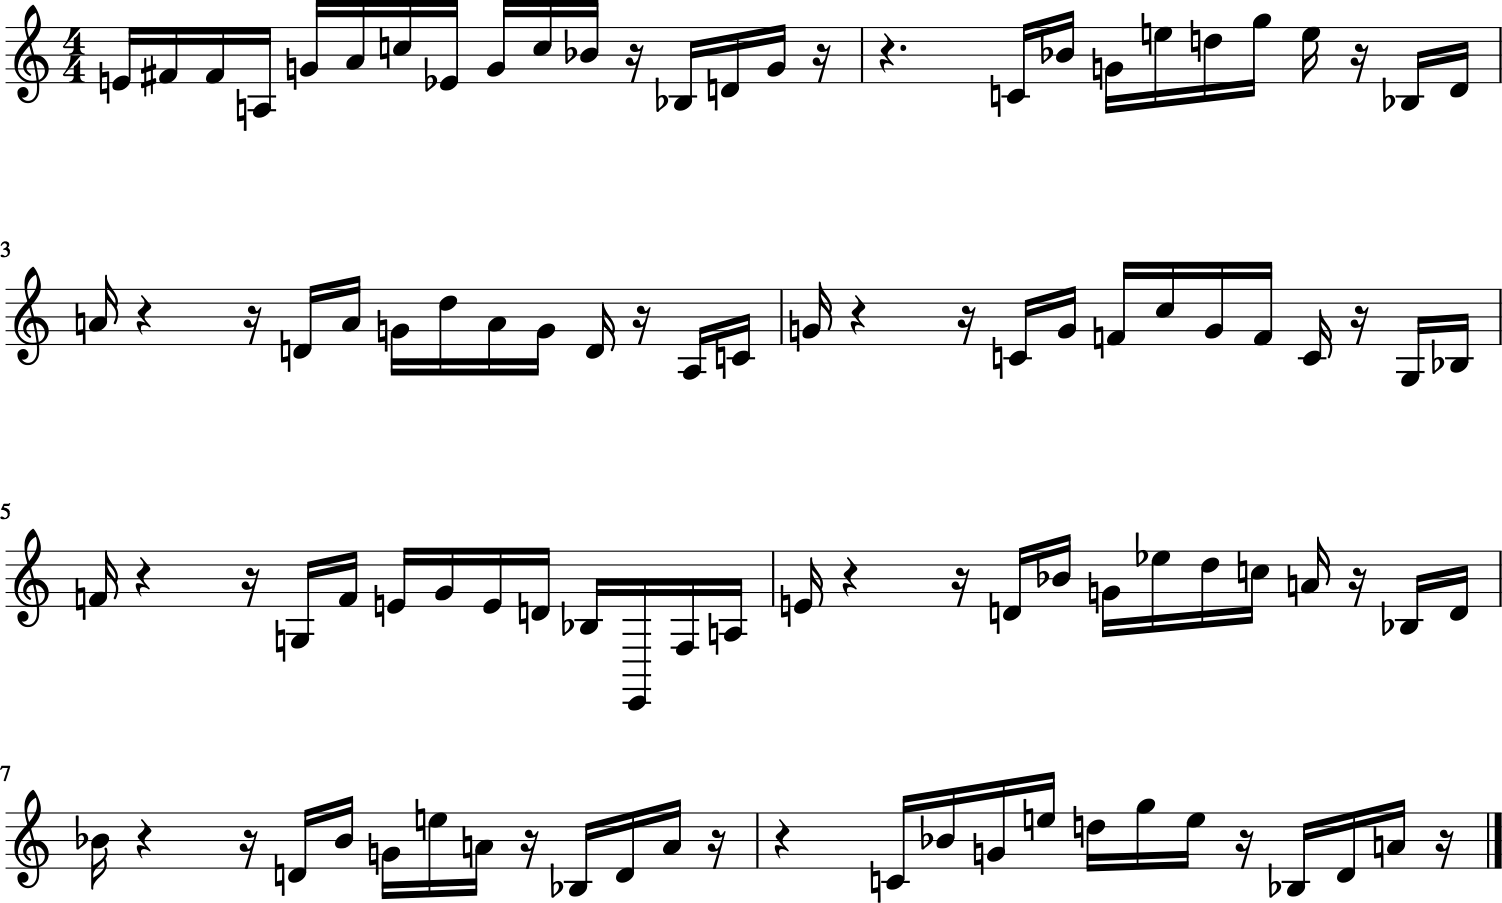

In [20]:
model_dec.reset_states() # Start with LSTM state blank
o = sample_model(64, model_dec, length=127, temperature=1.25) # generate 8 bars of melody

melody_stream = noteArrayToStream(o) # turn into a music21 stream
melody_stream.show() # show the score.


### Score example:

<!-- ![](figures/music_example.png) -->

# Play generated Melody

music21 can even play back a generated melody right in Jupyter! Cool!

In [22]:
## Pay a melody stream
sp = midi.realtime.StreamPlayer(melody_stream)
sp.play()

In [ ]:
from music21 import *
us = environment.UserSettings()
us.getSettingsPath()